In [1]:
# Import third-party packages.
import geopandas as gpd
from geopy.distance import geodesic
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from shapely.geometry import Point
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

%matplotlib inline

# Change display settings for dataframes.
pd.set_option('display.max_columns', None)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# Read in data on street trees.
df = pd.read_csv('./data/data_eda/data.csv.gz', compression='gzip')

## Creating a new feature n_neighbors: The number of trees in a tree's proximity. 

In [5]:
# Turn geographic coordinates into Shapely objects.
trees = gpd.GeoDataFrame(df, geometry=[Point(coordinates) for coordinates in zip(df['longitude'], df['latitude'])])

# Define CRS as WGS-84, then switch to a metric CRS.
trees.crs = {'init': 'epsg:4326', 'no_defs': True}
trees = trees.to_crs(epsg=3857)
trees.crs = {'init': 'epsg:3857', 'no_defs': True}

# Create circles with a 4.5m radius around each tree location. But since the radius of a tree might just touch another circle,
# the maximum distance between such trees should be 9m. This is also the upper minimal distance that should exist between trees.
buffers = trees.buffer(4.5)

# Set the Shapely objects for the circle to be in the WGS-84 CRS.
buffers = buffers.to_crs(epsg=4326)
buffers.crs = {'init': 'epsg:4326', 'no_defs': True}

# Switch the CRS again back to WGS-84.
trees = trees.to_crs(epsg=4326)
trees.crs = {'init': 'epsg:4326', 'no_defs': True}

C:\ProgramData\Anaconda3\lib\site-packages\pyproj\crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
C:\ProgramData\Anaconda3\lib\site-packages\pyproj\crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
C:\ProgramData\Anaconda3\lib\site-packages\pyproj\crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


In [6]:
# Turn the GeoSeries for the circles into a dataframe for a later sjoin.
circles = gpd.GeoDataFrame(buffers, geometry=buffers)
circles.rename(columns={0:'circles'}, inplace=True)

# Spatial join to find neighboring trees.
neighbors = gpd.sjoin(trees,
                      circles,
                      how='right',
                      op='intersects')
neighbors.drop(['index_left'], axis=1, inplace=True)
#neighbors.drop_duplicates(inplace=True)

# Count neighboring trees per tree.
n_neighbors = neighbors.groupby('tree_id').count()
n_neighbors.rename(columns={'circles': 'n_neighbors'}, inplace=True)

# Add tree counts to data of each tree.
df_new = pd.merge(df, n_neighbors[['n_neighbors']], on='tree_id', right_index=True)

In [7]:
# Add the count of neighboring trees to data on neighboring trees.
neighbors_counts = pd.merge(neighbors, n_neighbors['n_neighbors'], on='tree_id')

# Extract the latitudinal and longitudinal coordinates of each neighboring tree.
neighbors_counts['circs_lat'] = neighbors_counts['geometry'].centroid.y.values
neighbors_counts['circs_long'] = neighbors_counts['geometry'].centroid.x.values

# Calculate the distance in meters between a tree and its neighboring trees respectively.
neighbors_counts['distance'] = [geodesic((neighbors_counts['latitude'].loc[i], neighbors_counts['longitude'].loc[i]),
                                         (neighbors_counts['circs_lat'].loc[i], neighbors_counts['circs_long'].loc[i])).meters
                                for i in neighbors_counts.index]

In [8]:
# Find share of trees which have neighboring trees, given a circle with a 4.5m radius around each tree.
share_neighbors = neighbors_counts[neighbors_counts['n_neighbors'] > 1]['n_neighbors'].count() / len(neighbors_counts)
print("{} of all street trees in New York have a neighboring tree within 4.5m.".format(share_neighbors))

# Identify average distance of a street tree to another street tree in New York.
neighbors_counts[(neighbors_counts['n_neighbors'] > 1) & \
                 (neighbors_counts['circs_lat'] != neighbors_counts['latitude']) & \
                 (neighbors_counts['circs_long'] != neighbors_counts['longitude'])]['distance'].mean()

0.06679096724193123 of all street trees in New York have a neighboring tree within 4.5m.


1.4196490327659852

In [9]:
# Encode the new feature 'n_neighbors'.
df_new.loc[df_new['n_neighbors'] == 1, 'n_neighbors'] = 0.1
df_new.loc[df_new['n_neighbors'] == 2, 'n_neighbors'] = 0.2
df_new.loc[df_new['n_neighbors'] >= 3, 'n_neighbors'] = 0.3
df_new.loc[df_new['n_neighbors'] == 0.1, 'n_neighbors'] = "no neighbor"
df_new.loc[df_new['n_neighbors'] == 0.2, 'n_neighbors'] = "one neighbor"
df_new.loc[df_new['n_neighbors'] == 0.3, 'n_neighbors'] = "two or more neighbors"

In [ ]:
# Selecting variables for features and the target ('health').
df_sel = df_new[['tree_id',
                 'steward',
                 'guards',
                 'sidewalk',
                 'root_stone',
                 'root_grate',
                 'root_other',
                 'trunk_wire',
                 'trnk_light',
                 'trnk_other',
                 'brch_light',
                 'brch_shoe',
                 'brch_other',
                 'n_neighbors',
                 'health']]

# One-hot encoding the categorical features and the target.
df_sel_enc = pd.get_dummies(df_sel)

## Defining target variables

In [28]:
# Merge data of trees with a poor or a fair health characteristic.
df_sel_enc['health_Poor|Fair'] = df_sel_enc['health_Poor'] + df_sel_enc['health_Fair']
df_sel_enc.drop(['health_Poor', 'health_Fair'], axis=1, inplace=True)

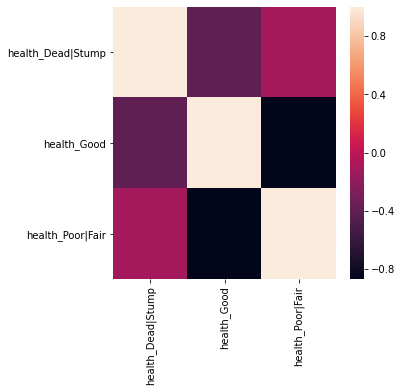

In [32]:
# Display correlations between target variables.
corrmat = df_sel_enc[list(df_sel_enc.columns)[31:]].corr()
plt.subplots(figsize=(5, 5))
sns.heatmap(corrmat, annot=False)
plt.show()

## Feature selection

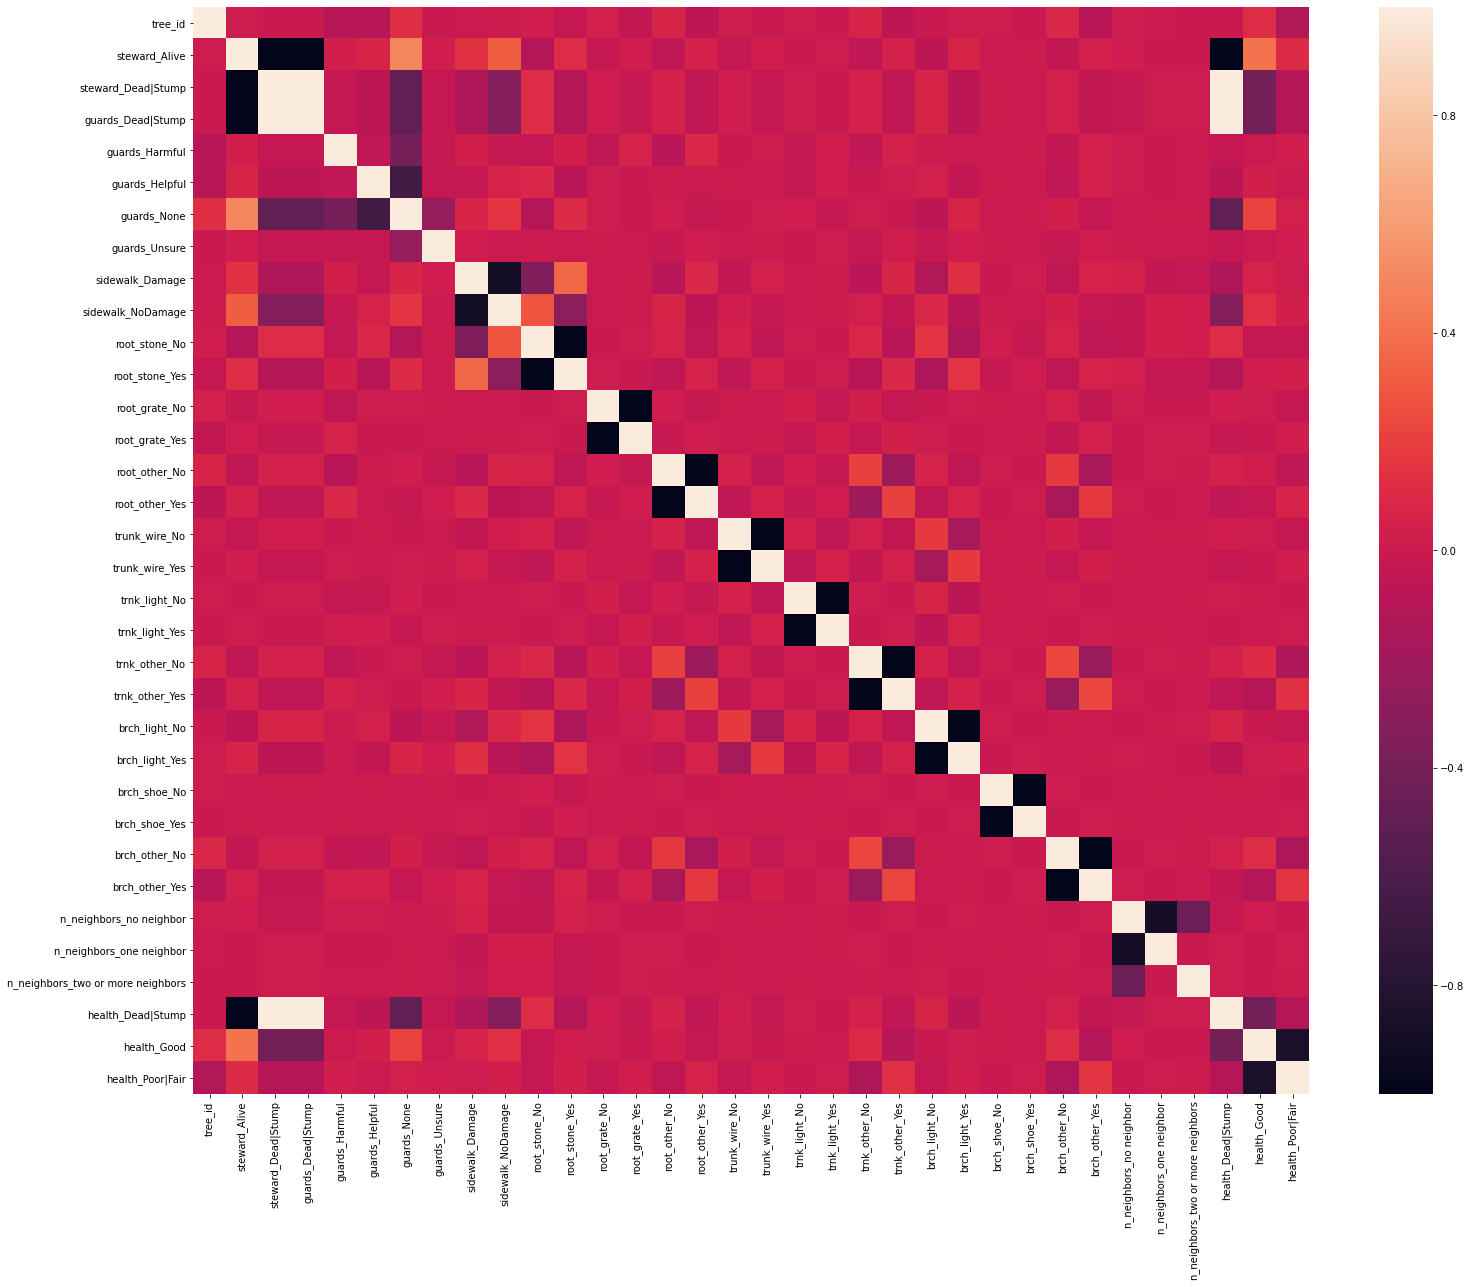

In [33]:
# Search for correlations between features (and target) categories.
corrmat = df_sel_enc.corr()
plt.subplots(figsize=(25, 20))
sns.heatmap(corrmat, annot=False)
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001CB7F0ED7B8>,
      dtype=object)

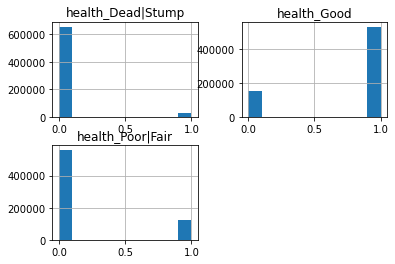

In [34]:
x = df_sel_enc[list(df_sel_enc.columns)[1:31]].values
y = df_sel_enc[list(df_sel_enc.columns)[31:]].values

# Plot the data on the target. The dataset is imbalanced.
y.hist()

In [35]:
# Conduct stratified splitting of the dataset.
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5, random_state=None, stratify=y)

In [36]:
# Run test with the RandomForestClassifier without balancing the dataset or hyperparameter tuning.
rdf_clf = RandomForestClassifier()
rdf_clf.fit(x_train, y_train)
y_pred = rdf_clf.predict(x_test)
print("The accuracy score for this run is:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=y.columns))

The accuracy score for this run is: 0.8217663954325025
                   precision    recall  f1-score   support

health_Dead|Stump       1.00      1.00      1.00     15808
      health_Good       0.82      0.99      0.90    264425
 health_Poor|Fair       0.59      0.04      0.07     61661

        micro avg       0.82      0.82      0.82    341894
        macro avg       0.80      0.68      0.66    341894
     weighted avg       0.78      0.82      0.75    341894
      samples avg       0.82      0.82      0.82    341894



In [37]:
# Inspect the importance of each feature.
feature_imp = pd.Series(rdf_clf.feature_importances_, index=x.columns).sort_values(ascending=False)
print(feature_imp)

steward_Dead|Stump                   0.261304
guards_Dead|Stump                    0.233613
steward_Alive                        0.226384
guards_None                          0.058715
sidewalk_Damage                      0.038296
brch_other_No                        0.030263
sidewalk_NoDamage                    0.027799
brch_other_Yes                       0.027713
trnk_other_Yes                       0.021562
trnk_other_No                        0.021174
guards_Harmful                       0.006597
root_stone_No                        0.006236
root_stone_Yes                       0.005787
guards_Helpful                       0.005232
root_other_Yes                       0.003966
root_other_No                        0.003501
guards_Unsure                        0.003183
brch_light_No                        0.002902
brch_light_Yes                       0.002435
trunk_wire_No                        0.002127
n_neighbors_no neighbor              0.001888
trunk_wire_Yes                    

In [39]:
# Training & pruning with model-based feature selection.
rdf_clf_sm = SelectFromModel(RandomForestClassifier(random_state=None), threshold='median')
rdf_clf_sm.fit(x_train, y_train)
x_train_fs = rdf_clf_sm.transform(x_train)
x_test_fs = rdf_clf_sm.transform(x_test)

rdf_clf_n = RandomForestClassifier(random_state=None).fit(x_train_fs, y_train)
y_pred_fs = rdf_clf_n.predict(x_test_fs)
accuracy = rdf_clf_n.score(x_test_fs, y_test)
print("Accuracy score:", accuracy)

Accuracy score: 0.8220442593318397


## Export feature / target dataframe as .csv file

In [44]:
df_sel_enc.to_csv('./data/data_preprocessed/features.csv', index=False)